Thermal Convection
======

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**This example introduces:**
1. Setting up material parameters and functions.
2. Setting up and solving systems, Stokes and Advection Diffusion.
3. The time stepping loop.
4. Plotting with glucifer.

![title](./images/02_veltemp.png)

**Keywords:** material parameters, Stokes system, advective diffusive systems

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

In [2]:
# Set python variables for model parameters.
boxHeight = 1.0
boxLength = 2.0
res = 16
tempMin = 0.0
tempMax = 1.0

In [3]:
# build a rectangular domain, discretised with a Q1/dQ0 elementType
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (2*res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

# create mesh variables.  Note the pressure field uses the sub-mesh (dQ0)
velocityField       = mesh.add_variable(         nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )
temperatureField    = mesh.add_variable(         nodeDofCount=1 )
temperatureDotField = mesh.add_variable(         nodeDofCount=1 ) # required for AdvectionDiffusion (SUPG) method

# Initialise values
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

In [4]:
# Setup python variabel and underworld.`function`

# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct our density `function`
densityFn = Ra * temperatureField
# '*' is overloaded. A multiplication of temperatureField (type MeshVariable)
# and a python float creates a `function`. See user_guide `Function` for more details

# Define our vertical unit vector using a python tuple (this will be converted to a function next).
z_hat = ( 0.0, 1.0 )

# a buoyancy force vector using the densityFn and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [5]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

Set top and bottom wall temperature boundary values.
Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions can be found in the **Systems** section of the user guide.

In [6]:
bottomWall = mesh.specialSets["MinJ_VertexSet"]
topWall    = mesh.specialSets["MaxJ_VertexSet"]
leftWall   = mesh.specialSets["MinI_VertexSet"]
rightWall  = mesh.specialSets["MaxI_VertexSet"]

for index in bottomWall:
    temperatureField.data[index] = tempMax
for index in topWall:
    temperatureField.data[index] = tempMin
    
# Construct sets for I (vertical) and J (horizontal) walls.
iWalls = leftWall   + rightWall
jWalls = bottomWall + topWall

In [7]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

**Render initial conditions for temperature**



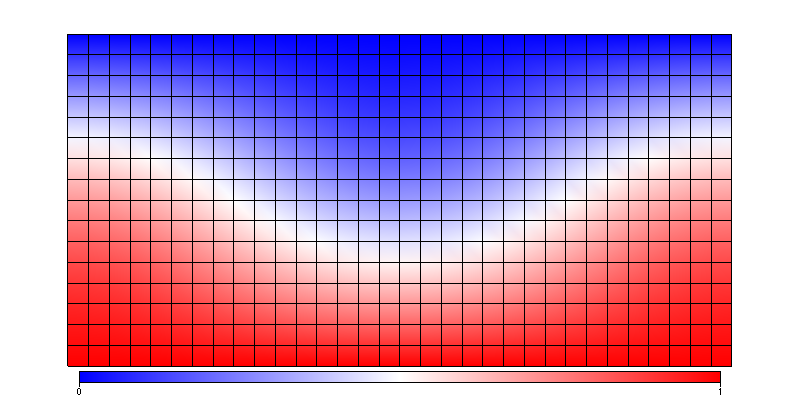

In [8]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the incompressible Stokes equations.  

In [9]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion solver can be found in the **Systems** section of the user guide

In [10]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = tempBC )

Main time stepping loop
-----

In [11]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection-diffusion system.
    dt = advDiff.get_max_dt()
    # Advect using this timestep size.
    advDiff.integrate(dt)
    return time+dt, step+1

In [12]:
# init these guys
time = 0.
step = 0
steps_end = 20

# perform timestepping
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    time, step = update()

**Plot final temperature and velocity field**


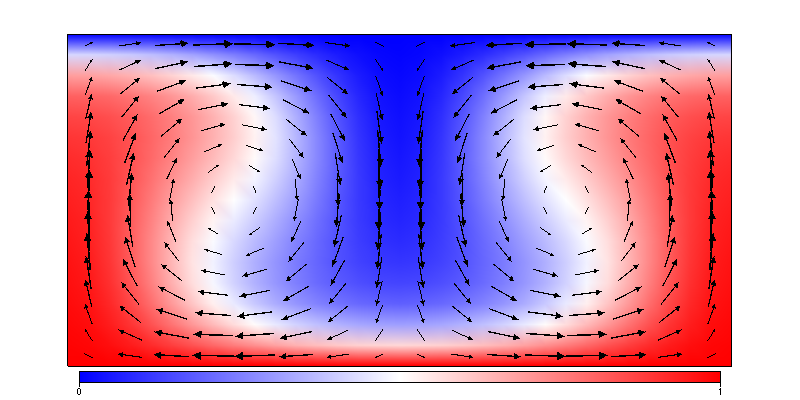

In [13]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()

In [14]:
# This cell is for testing purposes. It ensures the example computes the expected flow velocity rms values
import numpy as np

if not np.isclose(stokes.velocity_rms(), 8.70754e+01):
    raise RuntimeError("The Velocity RMS {:.5e} is not close to expected value".format(stokes.velocity_rms()))